# HubMap- Hacking the Kidney
#### Goal - Mapping the human body at functional tissue unit level - detect glomeruli FTUs in kidney

#### Implementation of Kaggle Notebook - Verifying TF-Records

Link - https://www.kaggle.com/marcosnovaes/hubmap-looking-at-tfrecords

###### Step 1 - Install useful libraries

In [2]:
%matplotlib inline
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import glob
import tifffile
import gc

###### Step 2 - Read meta-data csv files

In [23]:
basepath = r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Scripts\0. Pipeline\Output\output_train'
file_list = glob.glob(basepath+'/*.csv')
file_list

['C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Scripts\\0. Pipeline\\Output\\output_train\\0486052bb_tiles.csv',
 'C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Scripts\\0. Pipeline\\Output\\output_train\\095bf7a1f_tiles.csv',
 'C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Scripts\\0. Pipeline\\Output\\output_train\\1e2425f28_tiles.csv',
 'C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Scripts\\0. Pipeline\\Output\\output_train\\26dc41664_tiles.csv',
 'C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Scripts\\0. Pipeline\\Output\\output_train\\2f6ecfcdf_tiles.csv',
 'C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Scripts\\0. Pipeline\\Output\\output_train\\4ef6695ce_tiles.csv',
 'C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Scripts\\0. Pipeline\\Output\\output_train\\54f2eec69_tiles.csv',
 'C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Scripts\\0. Pipeline\\Output\\output_train\\8242609fa_tiles.csv',
 'C:\\Users\\soodn\\Down

In [24]:
import pandas as pd

train_df = pd.read_csv(file_list[0])
train_df.head()

,Unnamed: 0,img_index,img_id,tile_id,tile_rel_path,tile_col_num,tile_row_num,lowband_density,mask_density
0,0,6,0486052bb,0,0486052bb/col0_row0.tfrecords,0,0,0,0
1,1,6,0486052bb,1,0486052bb/col0_row1.tfrecords,0,1,0,0
2,2,6,0486052bb,2,0486052bb/col0_row2.tfrecords,0,2,0,0
3,3,6,0486052bb,3,0486052bb/col0_row3.tfrecords,0,3,0,0
4,4,6,0486052bb,4,0486052bb/col0_row4.tfrecords,0,4,0,0


In [25]:
list_img_id = train_df.loc[0]['img_id']
list_img_id

'0486052bb'

##### Step 3 - Get local path of the tfrecords (we can also get the gcs path in a similar fashion, if we wish to use TPUs)

In [28]:
# C:\Users\soodn\Downloads\Naveksha\hubmap-kidney-segmentation\output\train\2f6ecfcdf\col0
def get_tile_local_path(dataset,img_id, tile_row, tile_col):
    return 'Output/output_{}/{}/col{}/col{}_row{}.tfrecords'.format(dataset, img_id, tile_row, tile_row, tile_col)

In [32]:
local_tile_path = get_tile_local_path('train','0486052bb',0,3)
local_tile_path

'Output/output_train/0486052bb/col0/col0_row3.tfrecords'

###### Step 4 - Retrieve images from TFRecords

In [33]:
image_feature_description = {
    'img_index': tf.io.FixedLenFeature([], tf.int64),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'num_channels': tf.io.FixedLenFeature([], tf.int64),
    'img_bytes': tf.io.FixedLenFeature([], tf.string),
    'mask': tf.io.FixedLenFeature([], tf.string),
    'tile_id': tf.io.FixedLenFeature([], tf.int64),
    'tile_col_pos': tf.io.FixedLenFeature([], tf.int64),
    'tile_row_pos': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    img_index = single_example['img_index']
    img_height = single_example['height']
    img_width = single_example['width']
    num_channels = single_example['num_channels']
    
    img_bytes =  tf.io.decode_raw(single_example['img_bytes'],out_type='uint8')
   
    img_array = tf.reshape( img_bytes, (img_height, img_width, num_channels))
   
    mask_bytes =  tf.io.decode_raw(single_example['mask'],out_type='bool')
    
    mask = tf.reshape(mask_bytes, (img_height,img_width))
    mtd = dict()
    mtd['img_index'] = single_example['img_index']
    mtd['width'] = single_example['width']
    mtd['height'] = single_example['height']
    mtd['tile_id'] = single_example['tile_id']
    mtd['tile_col_pos'] = single_example['tile_col_pos']
    mtd['tile_row_pos'] = single_example['tile_row_pos']
    struct = {
        'img_array': img_array,
        'mask': mask,
        'mtd': mtd
    } 
    return struct

def read_tf_dataset(storage_file_path):
    encoded_image_dataset = tf.data.TFRecordDataset(storage_file_path, compression_type="GZIP")
    parsed_image_dataset = encoded_image_dataset.map(_parse_image_function)
    return parsed_image_dataset

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


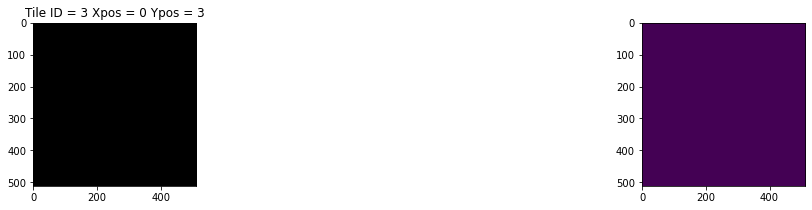

In [34]:
ds = read_tf_dataset(local_tile_path)

for struct in ds.as_numpy_iterator():
    img_mtd = struct["mtd"]
    img_array  = struct["img_array"]
    img_mask = struct["mask"]
 
    fig, ax = plt.subplots(1,2,figsize=(20,3))
    ax[0].set_title("Tile ID = {} Xpos = {} Ypos = {}".format(img_mtd['tile_id'], img_mtd['tile_col_pos'],img_mtd['tile_row_pos']))
    ax[0].imshow(img_array)
    ax[1].imshow(img_mask)

##### Step 5 - Build a dataset of image tiles with gloms

In [36]:
# build a dataset of all image tiles from image 0 that have gloms in them
csv_file = file_list[1]
tiles_df = pd.read_csv(csv_file)
gloms_df = tiles_df.loc[tiles_df["mask_density"]  > 0]

gloms_df.head()

,Unnamed: 0,img_index,img_id,tile_id,tile_rel_path,tile_col_num,tile_row_num,lowband_density,mask_density
636,636,8,095bf7a1f,636,095bf7a1f/col8_row28.tfrecords,8,28,238534,31649
711,711,8,095bf7a1f,711,095bf7a1f/col9_row27.tfrecords,9,27,268044,20500
712,712,8,095bf7a1f,712,095bf7a1f/col9_row28.tfrecords,9,28,354847,112176
786,786,8,095bf7a1f,786,095bf7a1f/col10_row26.tfrecords,10,26,239831,1852
787,787,8,095bf7a1f,787,095bf7a1f/col10_row27.tfrecords,10,27,336154,54982


In [37]:
tile_path_array = []
num_tiles = gloms_df.__len__()
for index in range(num_tiles) :
    dataset_name = 'train'
    img_id = gloms_df.iloc[index]['img_id']
    col_offset = gloms_df.iloc[index]['tile_col_num']
    row_offset = gloms_df.iloc[index]['tile_row_num']
    tile_path = get_tile_local_path(dataset_name, img_id,col_offset,row_offset)
    tile_path_array.append(tile_path)

In [38]:
# check the first 5 paths to see if they are correct
tile_path_array[0:5]

['Output/output_train/095bf7a1f/col8/col8_row28.tfrecords',
 'Output/output_train/095bf7a1f/col9/col9_row27.tfrecords',
 'Output/output_train/095bf7a1f/col9/col9_row28.tfrecords',
 'Output/output_train/095bf7a1f/col10/col10_row26.tfrecords',
 'Output/output_train/095bf7a1f/col10/col10_row27.tfrecords']

##### Step 6 - View some of those tiles

In [39]:
# reat the dataset passing all the file names
ds = read_tf_dataset(tile_path_array[0:5])
#read 5 images and masks using the numpy iterator
glom_mtd = []
glom_tiles = []
glom_masks = []

for struct in ds.as_numpy_iterator():
    img_mtd = struct["mtd"]
    glom_mtd.append(img_mtd)
    img_array  = struct["img_array"]
    glom_tiles.append(img_array)
    img_mask = struct["mask"]
    glom_masks.append(img_mask)

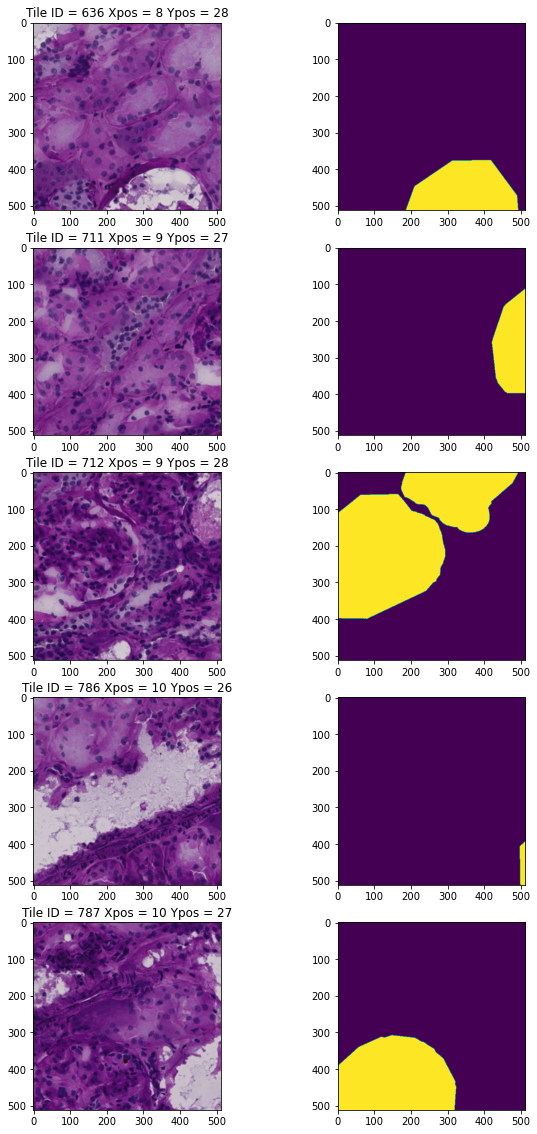

In [40]:
#plot the 5 glom tiles from the dataset
fig, ax = plt.subplots(5,2,figsize=(10,20))
ax[0][0].set_title("Tile ID = {} Xpos = {} Ypos = {}".format(glom_mtd[0]['tile_id'], glom_mtd[0]['tile_col_pos'],glom_mtd[0]['tile_row_pos']))
ax[0][0].imshow(glom_tiles[0])
ax[0][1].imshow(glom_masks[0])

ax[1][0].set_title("Tile ID = {} Xpos = {} Ypos = {}".format(glom_mtd[1]['tile_id'], glom_mtd[1]['tile_col_pos'],glom_mtd[1]['tile_row_pos']))
ax[1][0].imshow(glom_tiles[1])
ax[1][1].imshow(glom_masks[1])

ax[2][0].set_title("Tile ID = {} Xpos = {} Ypos = {}".format(glom_mtd[2]['tile_id'], glom_mtd[2]['tile_col_pos'],glom_mtd[2]['tile_row_pos']))
ax[2][0].imshow(glom_tiles[2])
ax[2][1].imshow(glom_masks[2])

ax[3][0].set_title("Tile ID = {} Xpos = {} Ypos = {}".format(glom_mtd[3]['tile_id'], glom_mtd[3]['tile_col_pos'],glom_mtd[3]['tile_row_pos']))
ax[3][0].imshow(glom_tiles[3])
ax[3][1].imshow(glom_masks[3])

ax[4][0].set_title("Tile ID = {} Xpos = {} Ypos = {}".format(glom_mtd[4]['tile_id'], glom_mtd[4]['tile_col_pos'],glom_mtd[4]['tile_row_pos']))
ax[4][0].imshow(glom_tiles[4])
ax[4][1].imshow(glom_masks[4])

In [44]:
# create a uber lits of all tiles for all images. Include local and cloud paths for each tile
def create_dataset_file_info(dataset_name):
    file_list = glob.glob('Output/output_'+dataset_name+'/*.csv'.format(dataset_name))
    uber_tile_df = pd.DataFrame(columns = ['img_id','tile_id','tile_row_index', 'tile_col_index', 'lowband_density', 'mask_density','local_path'])
    for file_name in file_list:
            tile_df = pd.read_csv(file_name)
            num_tiles = tile_df.__len__()
            for index in range(num_tiles):
                img_id = tile_df.iloc[index]['img_id']
                tile_id = tile_df.iloc[index]['tile_id']
                tile_col_num = tile_df.iloc[index]['tile_col_num']
                tile_row_num = tile_df.iloc[index]['tile_row_num']
                lowband_density = tile_df.iloc[index]['lowband_density']
                mask_density = tile_df.iloc[index]['mask_density']           
                local_tile_path = get_tile_local_path(dataset_name,img_id, tile_col_num, tile_row_num )
                
                uber_tile_df = uber_tile_df.append({'img_id':img_id, 'tile_id': tile_id, 'tile_row_index':tile_col_num, 'tile_col_index':tile_row_num,
                                                     'lowband_density':lowband_density, 'mask_density':mask_density,
                                                     'local_path':local_tile_path},ignore_index=True)
    #write the dataframe
    print('writing tile metadata for dataset {}'.format(dataset_name))
    output_file_name = 'output_'+dataset_name+'_all_tiles.csv'
    uber_tile_df.to_csv('Output/'+output_file_name)
    return uber_tile_df

###### Step 7: Make a large dataframe for train and test

In [45]:
uber_train = create_dataset_file_info('train')
uber_train.head()

writing tile metadata for dataset train


,img_id,tile_id,tile_row_index,tile_col_index,lowband_density,mask_density,local_path
0,0486052bb,0,0,0,0,0,Output/output_train/0486052bb/col0/col0_row0.t...
1,0486052bb,1,0,1,0,0,Output/output_train/0486052bb/col0/col0_row1.t...
2,0486052bb,2,0,2,0,0,Output/output_train/0486052bb/col0/col0_row2.t...
3,0486052bb,3,0,3,0,0,Output/output_train/0486052bb/col0/col0_row3.t...
4,0486052bb,4,0,4,0,0,Output/output_train/0486052bb/col0/col0_row4.t...


In [36]:
uber_test = create_dataset_file_info('test')
uber_test.head()

writing tile metadata for dataset test


,img_id,tile_id,tile_row_index,tile_col_index,lowband_density,mask_density,local_path
0,2ec3f1bb9,0,0,0,0,0,output_test/2ec3f1bb9/col0/col0_row0.tfrecords
1,2ec3f1bb9,1,0,1,0,0,output_test/2ec3f1bb9/col0/col0_row1.tfrecords
2,2ec3f1bb9,2,0,2,0,0,output_test/2ec3f1bb9/col0/col0_row2.tfrecords
3,2ec3f1bb9,3,0,3,423423,0,output_test/2ec3f1bb9/col0/col0_row3.tfrecords
4,2ec3f1bb9,4,0,4,160,0,output_test/2ec3f1bb9/col0/col0_row4.tfrecords


##### Caveats - 
1. Use GCS for TPU use.